## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../all.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,5.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.505230,4.200000,60.951418,...,94.220000,1034.960009,1033.440000,1037.220000,270.313918,194.000000,328.400000,4.257234,1.920000,5.860000
1,1.400000,143.0,210.0,1.72,218.0,94.6,0.434,2.479167,4.000000,60.812500,...,95.900000,1034.843750,1031.700000,1038.100000,259.770833,227.000000,339.000000,5.036170,2.000000,6.200000
2,2.742857,143.0,210.0,1.72,218.0,94.6,0.434,2.639881,3.571429,64.693452,...,92.528571,1025.654167,1022.557143,1028.500000,246.068452,156.428571,311.714286,5.367262,3.328571,7.528571
3,1.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.895833,4.000000,64.312500,...,93.500000,1024.008333,1020.000000,1027.300000,251.979167,213.000000,300.000000,4.456250,2.500000,7.700000
4,14.614286,143.0,210.0,1.72,218.0,94.6,0.434,3.446429,5.857143,71.940476,...,91.314286,1015.603869,1011.585714,1020.142857,210.104167,169.714286,266.285714,5.892857,3.800000,7.757143


In [2]:
df.shape

(3174, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((3150, 24, 34), (3150,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2539, 24, 34), (2539,), (317, 24, 34), (317,), (294, 24, 34), (294,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

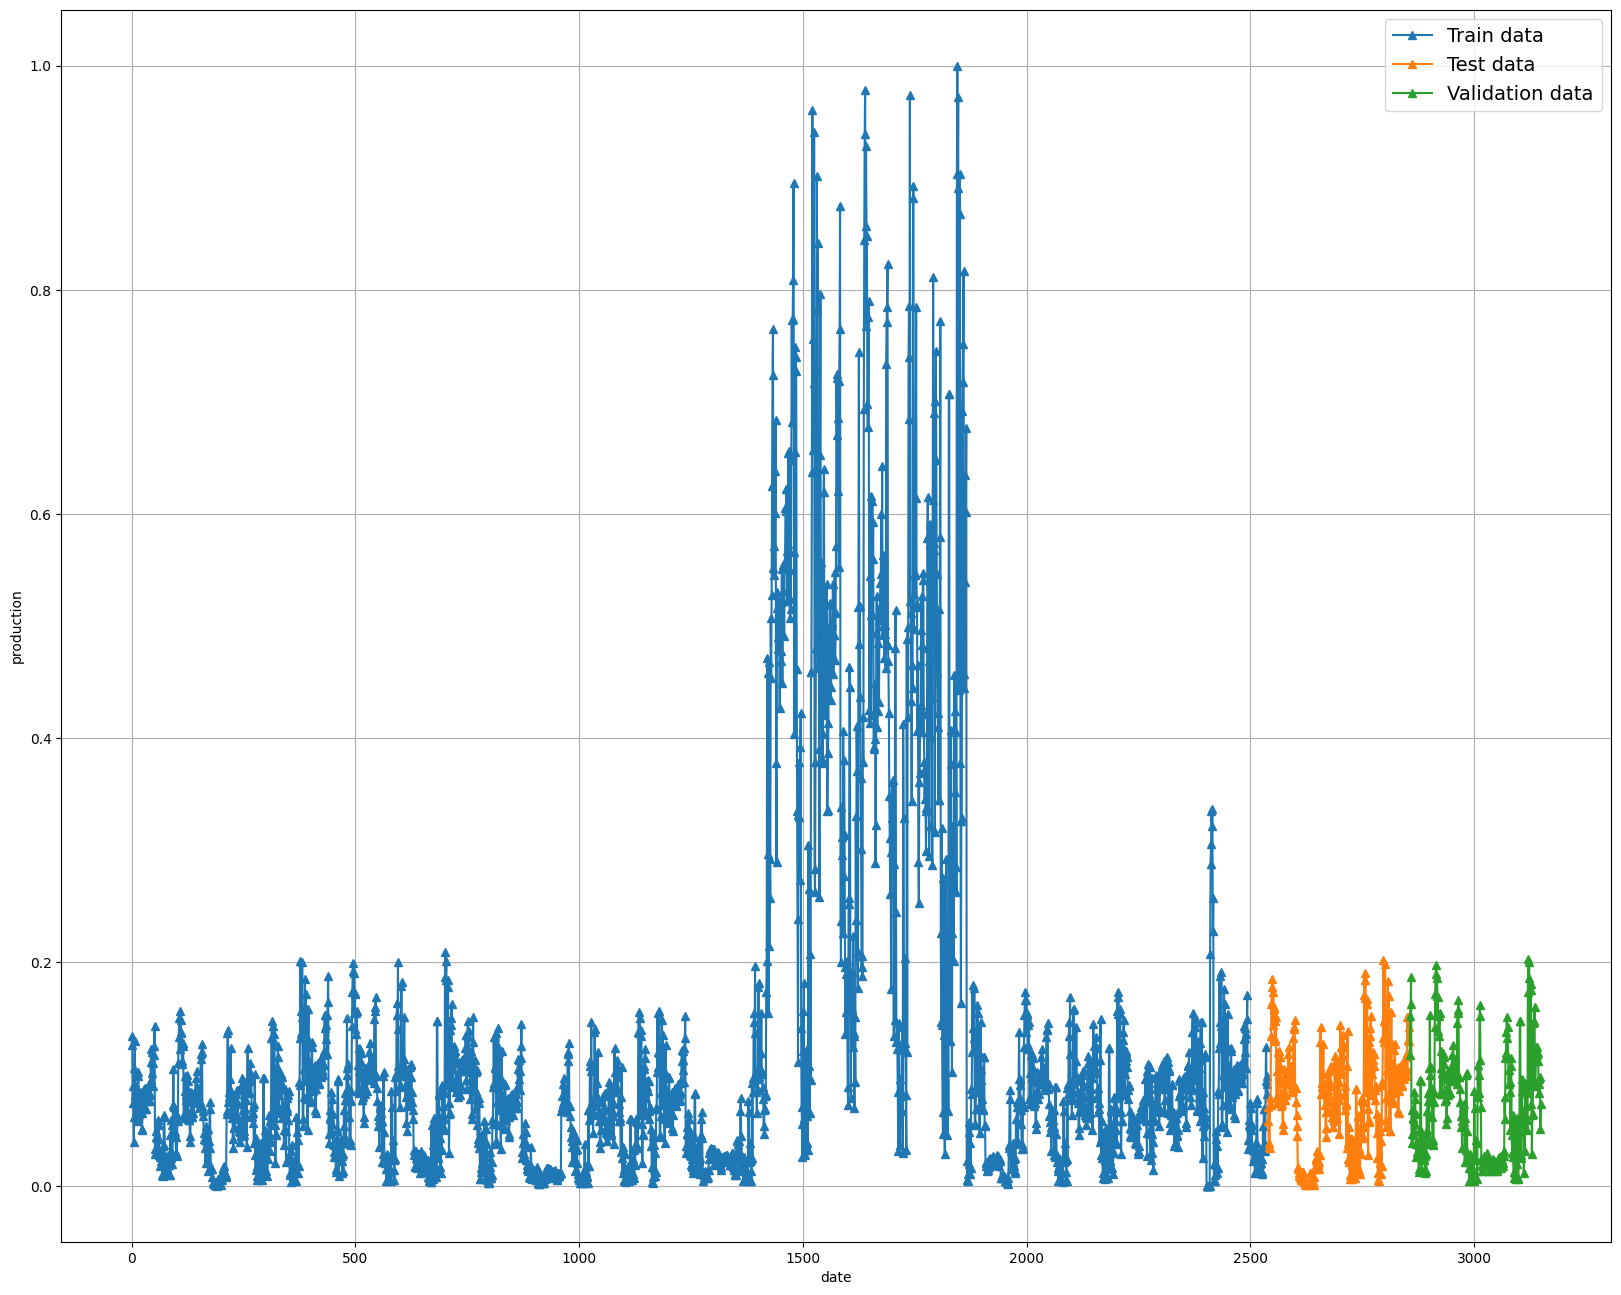

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(2539, 24, 34) -> (2539, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=96, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0016163507080940505))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 96)           │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,633 (365.75 KB)

 Trainable params: 93,633 (365.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 23:57:47] [setup] RAM Tracking...
[codecarbon INFO @ 23:57:47] [setup] CPU Tracking...
[codecarbon WARNING @ 23:57:47] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 23:57:48] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 23:57:48] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 23:57:48] [setup] GPU Tracking...
[codecarbon INFO @ 23:57:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:57:48] >>> Tracker's metadata:
[codecarbon INFO @ 23:57:49]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 23:57:49]   Python version: 3.12.3
[codecarbon INFO @ 23:57:49]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 23:57:49]   Available RAM : 15.288 GB
[codecarbon INFO @ 23:57:49]   CPU count: 16
[codecarbon INFO @ 23:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 0.2232 - val_loss: 0.1014
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.1253 - val_loss: 0.0383
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0813 - val_loss: 0.0397
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0680 - val_loss: 0.0366
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0571 - val_loss: 0.0335
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0543 - val_loss: 0.0341
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0523 - val_loss: 0.0342
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0517 - val_loss: 0.0340
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0505 - val_loss: 0.0336
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0497 - val_loss: 0.0342
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0487 - val_loss: 0.0335
Epoch 12/300


[codecarbon INFO @ 23:57:59] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:57:59] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:59] Energy consumed for all GPUs : 0.000008 kWh. Total GPU Power : 2.714104012231066 W
[codecarbon INFO @ 23:57:59] 0.000142 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0482 - val_loss: 0.0342
Epoch 13/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0478 - val_loss: 0.0332
Epoch 14/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0473 - val_loss: 0.0335
Epoch 15/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0467 - val_loss: 0.0326
Epoch 16/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0463 - val_loss: 0.0329
Epoch 17/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0458 - val_loss: 0.0321
Epoch 18/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0459 - val_loss: 0.0333
Epoch 19/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0461 - val_loss: 0.0329
Epoch 20/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0450 - val_loss: 0.0327
Epoch 21/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0449 - val_loss: 0.0317
Epoch 22/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0443 - val_loss: 0.0313
Epoch 23/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0435 - val_lo

[codecarbon INFO @ 23:58:09] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0407

[codecarbon INFO @ 23:58:09] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:09] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 4.89052520532068 W
[codecarbon INFO @ 23:58:09] 0.000290 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0409 - val_loss: 0.0292
Epoch 33/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0406 - val_loss: 0.0341
Epoch 34/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0450 - val_loss: 0.0295
Epoch 35/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0421 - val_loss: 0.0309
Epoch 36/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0415 - val_loss: 0.0343
Epoch 37/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0424 - val_loss: 0.0311
Epoch 38/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0407 - val_loss: 0.0297
Epoch 39/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0403 - val_loss: 0.0287
Epoch 40/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0394 - val_loss: 0.0284
Epoch 41/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0385 - val_loss: 0.0276
Epoch 42/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0385 - val_loss: 0.0286
Epoch 43/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0395 - val_loss

[codecarbon INFO @ 23:58:19] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:58:19] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0355

[codecarbon INFO @ 23:58:19] Energy consumed for all GPUs : 0.000040 kWh. Total GPU Power : 6.8531824570670805 W
[codecarbon INFO @ 23:58:19] 0.000443 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0356 - val_loss: 0.0266
Epoch 54/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0374 - val_loss: 0.0256
Epoch 55/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0371 - val_loss: 0.0260
Epoch 56/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0365 - val_loss: 0.0268
Epoch 57/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0362 - val_loss: 0.0265
Epoch 58/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0360 - val_loss: 0.0246
Epoch 59/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0351 - val_loss: 0.0247
Epoch 60/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0362 - val_loss: 0.0262
Epoch 61/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0371 - val_loss: 0.0275
Epoch 62/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0357 - val_loss: 0.0257
Epoch 63/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0363 - val_loss: 0.0258
Epoch 64/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0350 - val_loss:

[codecarbon INFO @ 23:58:29] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:58:29] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0340

[codecarbon INFO @ 23:58:29] Energy consumed for all GPUs : 0.000049 kWh. Total GPU Power : 2.977519302646818 W
[codecarbon INFO @ 23:58:29] 0.000585 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0334 - val_loss: 0.0227
Epoch 76/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0335 - val_loss: 0.0235
Epoch 77/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0330 - val_loss: 0.0238
Epoch 78/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0324 - val_loss: 0.0227
Epoch 79/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0336 - val_loss: 0.0222
Epoch 80/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0330 - val_loss: 0.0249
Epoch 81/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0332 - val_loss: 0.0220
Epoch 82/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0327 - val_loss: 0.0223
Epoch 83/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0318 - val_loss: 0.0231
Epoch 84/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0319 - val_loss: 0.0220
Epoch 85/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0327 - val_loss: 0.0222
Epoch 86/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0323 - val_loss: 

[codecarbon INFO @ 23:58:39] Energy consumed for RAM : 0.000079 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:58:39] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:39] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 8.209843567329234 W
[codecarbon INFO @ 23:58:39] 0.000742 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0307 - val_loss: 0.0211
Epoch 97/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0307 - val_loss: 0.0206
Epoch 98/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0319 - val_loss: 0.0206
Epoch 99/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0310 - val_loss: 0.0228
Epoch 100/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0307 - val_loss: 0.0206
Epoch 101/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0301 - val_loss: 0.0201
Epoch 102/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0306 - val_loss: 0.0212
Epoch 103/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0303 - val_loss: 0.0217
Epoch 104/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0308 - val_loss: 0.0201
Epoch 105/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0298 - val_loss: 0.0218
Epoch 106/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0314 - val_loss: 0.0214
Epoch 107/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0305 - va

[codecarbon INFO @ 23:58:49] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:58:49] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:49] Energy consumed for all GPUs : 0.000094 kWh. Total GPU Power : 8.25117781275392 W
[codecarbon INFO @ 23:58:49] 0.000899 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0286 - val_loss: 0.0203
Epoch 120/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0287 - val_loss: 0.0198
Epoch 121/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0282 - val_loss: 0.0194
Epoch 122/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0278 - val_loss: 0.0202
Epoch 123/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0292 - val_loss: 0.0197
Epoch 124/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0292 - val_loss: 0.0199
Epoch 125/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0287 - val_loss: 0.0200
Epoch 126/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0289 - val_loss: 0.0185
Epoch 127/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0285 - val_loss: 0.0208
Epoch 128/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0295 - val_loss: 0.0201
Epoch 129/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0289 - val_loss: 0.0199
Epoch 130/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0287 -

[codecarbon INFO @ 23:58:59] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:58:59] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0289

[codecarbon INFO @ 23:58:59] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 3.3532386687373266 W
[codecarbon INFO @ 23:58:59] 0.001042 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0291 - val_loss: 0.0206
Epoch 141/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0296 - val_loss: 0.0184
Epoch 142/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0275 - val_loss: 0.0200
Epoch 143/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0271 - val_loss: 0.0187
Epoch 144/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0280 - val_loss: 0.0190
Epoch 145/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0275 - val_loss: 0.0179
Epoch 146/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0265 - val_loss: 0.0184
Epoch 147/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0268 - val_loss: 0.0178
Epoch 148/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0278 - val_loss: 0.0179
Epoch 149/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0272 - val_loss: 0.0177
Epoch 150/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0267 - val_loss: 0.0179
Epoch 151/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0276 

[codecarbon INFO @ 23:59:09] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:59:09] Energy consumed for all CPUs : 0.000945 kWh. Total CPU Power : 42.5 W


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0253

[codecarbon INFO @ 23:59:09] Energy consumed for all GPUs : 0.000115 kWh. Total GPU Power : 4.24389525499891 W
[codecarbon INFO @ 23:59:09] 0.001188 kWh of electricity used since the beginning.
[codecarbon ERROR @ 23:59:09] co2_signal.get_emissions: HTTPSConnectionPool(host='api.co2signal.com', port=443): Max retries exceeded with url: /v1/latest?lat=46.8&lon=-71.2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001C859CB5DF0>: Failed to resolve 'api.co2signal.com' ([Errno 11001] getaddrinfo failed)")) >>> Using CodeCarbon's data.
[codecarbon INFO @ 23:59:09] 0.000035 g.CO2eq/s mean an estimation of 1.111629978663614 kg.CO2eq/year


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0257 - val_loss: 0.0189
Epoch 163/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0264 - val_loss: 0.0178
Epoch 164/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0264 - val_loss: 0.0206
Epoch 165/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0269 - val_loss: 0.0171
Epoch 166/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0264 - val_loss: 0.0207
Epoch 167/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0268 - val_loss: 0.0191
Epoch 168/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0270 - val_loss: 0.0182
Epoch 169/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0261 - val_loss: 0.0190
Epoch 170/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0261 - val_loss: 0.0179
Epoch 171/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0254 - val_loss: 0.0178
Epoch 172/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0253 - val_loss: 0.0183
Epoch 173/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0253 

[codecarbon INFO @ 23:59:19] Energy consumed for RAM : 0.000143 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:59:19] Energy consumed for all CPUs : 0.001064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:19] Energy consumed for all GPUs : 0.000130 kWh. Total GPU Power : 5.407972821502609 W
[codecarbon INFO @ 23:59:19] 0.001337 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0246 - val_loss: 0.0187
Epoch 185/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0247 - val_loss: 0.0182
Epoch 186/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0246 - val_loss: 0.0182
Epoch 187/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0258 - val_loss: 0.0214
Epoch 188/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0264 - val_loss: 0.0194
Epoch 189/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0254 - val_loss: 0.0187
Epoch 190/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0245 - val_loss: 0.0184
Epoch 191/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0252 - val_loss: 0.0188
Epoch 192/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0245 - val_loss: 0.0174
Epoch 193/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0246 - val_loss: 0.0169
Epoch 194/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0240 - val_loss: 0.0184
Epoch 195/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0241 -

[codecarbon INFO @ 23:59:29] Energy consumed for RAM : 0.000159 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:59:29] Energy consumed for all CPUs : 0.001181 kWh. Total CPU Power : 42.5 W


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0238 - val_loss: 0.0175


[codecarbon INFO @ 23:59:29] Energy consumed for all GPUs : 0.000151 kWh. Total GPU Power : 7.30260986574957 W


Epoch 207/300


[codecarbon INFO @ 23:59:29] 0.001491 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0240 - val_loss: 0.0180
Epoch 208/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0229 - val_loss: 0.0170
Epoch 209/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0227 - val_loss: 0.0175
Epoch 210/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0222 - val_loss: 0.0160
Epoch 211/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0221 - val_loss: 0.0161
Epoch 212/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0228 - val_loss: 0.0172
Epoch 213/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0229 - val_loss: 0.0188
Epoch 214/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0248 - val_loss: 0.0174
Epoch 215/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0229 - val_loss: 0.0172
Epoch 216/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0240 - val_loss: 0.0169
Epoch 217/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0233 - val_loss: 0.0177
Epoch 218/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0235 -

[codecarbon INFO @ 23:59:39] Energy consumed for RAM : 0.000175 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:59:39] Energy consumed for all CPUs : 0.001300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:39] Energy consumed for all GPUs : 0.000167 kWh. Total GPU Power : 5.885305871210641 W


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0206

[codecarbon INFO @ 23:59:39] 0.001642 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0214 - val_loss: 0.0165
Epoch 230/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0223 - val_loss: 0.0176
Epoch 231/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0222 - val_loss: 0.0166
Epoch 232/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0217 - val_loss: 0.0162
Epoch 233/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0215 - val_loss: 0.0163
Epoch 234/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0210 - val_loss: 0.0162
Epoch 235/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0207 - val_loss: 0.0155
Epoch 236/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0212 - val_loss: 0.0152
Epoch 237/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0205 - val_loss: 0.0156
Epoch 238/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0201 - val_loss: 0.0162
Epoch 239/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0212 - val_loss: 0.0176
Epoch 240/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0212 -

[codecarbon INFO @ 23:59:49] Energy consumed for RAM : 0.000191 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:59:49] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0210

[codecarbon INFO @ 23:59:49] Energy consumed for all GPUs : 0.000176 kWh. Total GPU Power : 3.1061171806815144 W
[codecarbon INFO @ 23:59:49] 0.001784 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0214 - val_loss: 0.0151
Epoch 252/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0202 - val_loss: 0.0156
Epoch 253/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0200 - val_loss: 0.0179
Epoch 254/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0212 - val_loss: 0.0189
Epoch 255/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0223 - val_loss: 0.0154
Epoch 256/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0218 - val_loss: 0.0160
Epoch 257/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0212 - val_loss: 0.0178
Epoch 258/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0211 - val_loss: 0.0167
Epoch 259/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0208 - val_loss: 0.0167
Epoch 260/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0197 - val_loss: 0.0165
Epoch 261/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0203 - val_loss: 0.0160
Epoch 262/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0196 -

[codecarbon INFO @ 23:59:59] Energy consumed for RAM : 0.000207 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 23:59:59] Energy consumed for all CPUs : 0.001536 kWh. Total CPU Power : 42.5 W


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0189

[codecarbon INFO @ 23:59:59] Energy consumed for all GPUs : 0.000189 kWh. Total GPU Power : 4.946716624168519 W
[codecarbon INFO @ 23:59:59] 0.001932 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0189 - val_loss: 0.0162
Epoch 274/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0194 - val_loss: 0.0146
Epoch 275/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0189 - val_loss: 0.0156
Epoch 276/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0195 - val_loss: 0.0155
Epoch 277/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0188 - val_loss: 0.0156
Epoch 278/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0184 - val_loss: 0.0145
Epoch 279/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0186 - val_loss: 0.0157
Epoch 280/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0185 - val_loss: 0.0146
Epoch 281/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0182 - val_loss: 0.0156
Epoch 282/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0193 - val_loss: 0.0155
Epoch 283/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0196 - val_loss: 0.0152
Epoch 284/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0189 -

[codecarbon INFO @ 00:00:09] Energy consumed for RAM : 0.000222 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 00:00:09] Energy consumed for all CPUs : 0.001654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:09] Energy consumed for all GPUs : 0.000202 kWh. Total GPU Power : 4.658283328243772 W
[codecarbon INFO @ 00:00:09] 0.002079 kWh of electricity used since the beginning.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0174 - val_loss: 0.0145
Epoch 297/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0173 - val_loss: 0.0143
Epoch 298/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0173 - val_loss: 0.0155
Epoch 299/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0177 - val_loss: 0.0160
Epoch 300/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0178 - val_loss: 0.0170


[codecarbon INFO @ 00:00:11] Energy consumed for RAM : 0.000226 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 00:00:11] Energy consumed for all CPUs : 0.001679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:11] Energy consumed for all GPUs : 0.000209 kWh. Total GPU Power : 10.565956357942113 W
[codecarbon INFO @ 00:00:11] 0.002114 kWh of electricity used since the beginning.
[codecarbon ERROR @ 00:00:11] co2_signal.get_emissions: HTTPSConnectionPool(host='api.co2signal.com', port=443): Max retries exceeded with url: /v1/latest?lat=46.8&lon=-71.2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001C857FD7230>: Failed to resolve 'api.co2signal.com' ([Errno 11001] getaddrinfo failed)")) >>> Using CodeCarbon's data.


#### Ploting the loss

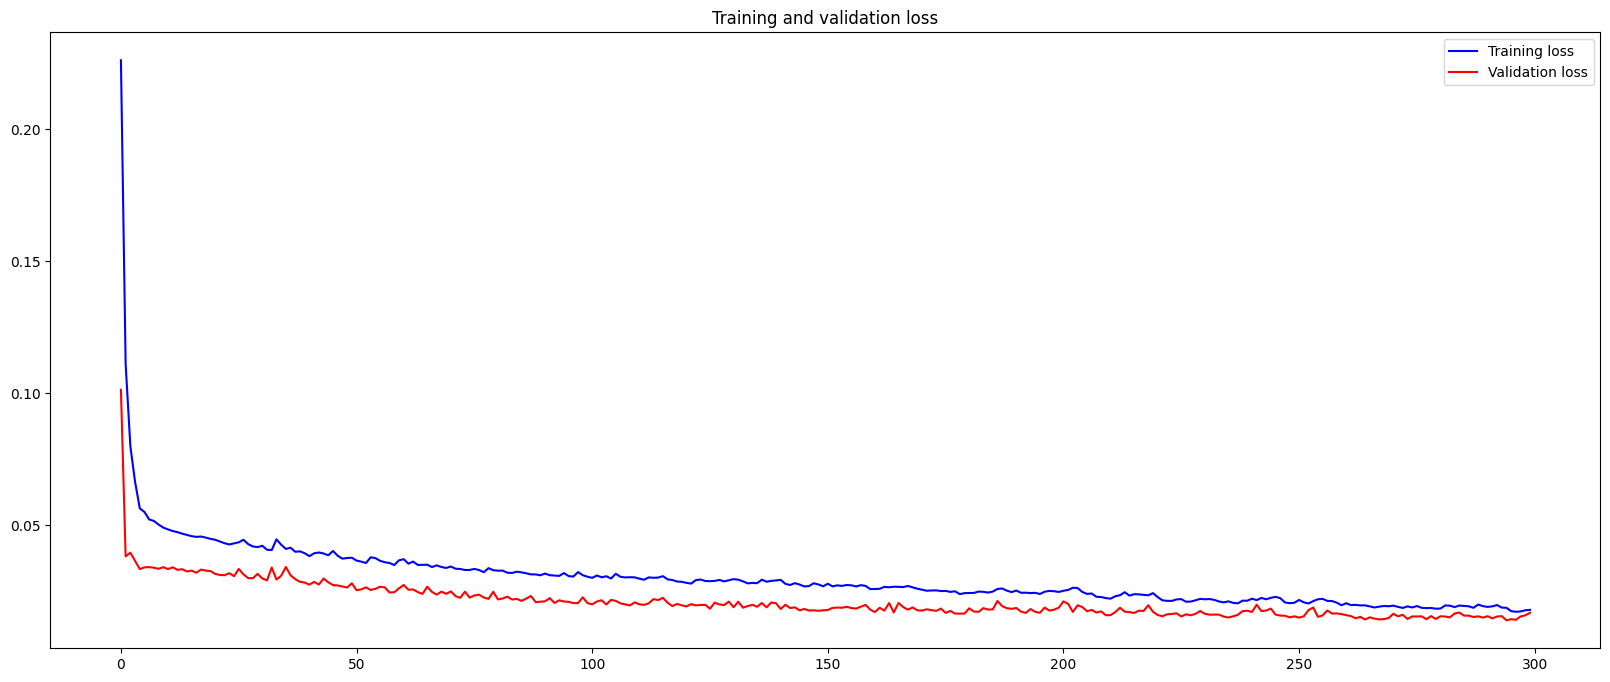

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step 


{'mae': np.float32(0.011920387),
 'mse': np.float32(0.00028265343),
 'r2': 0.8766235709190369}

#### Plot predictions

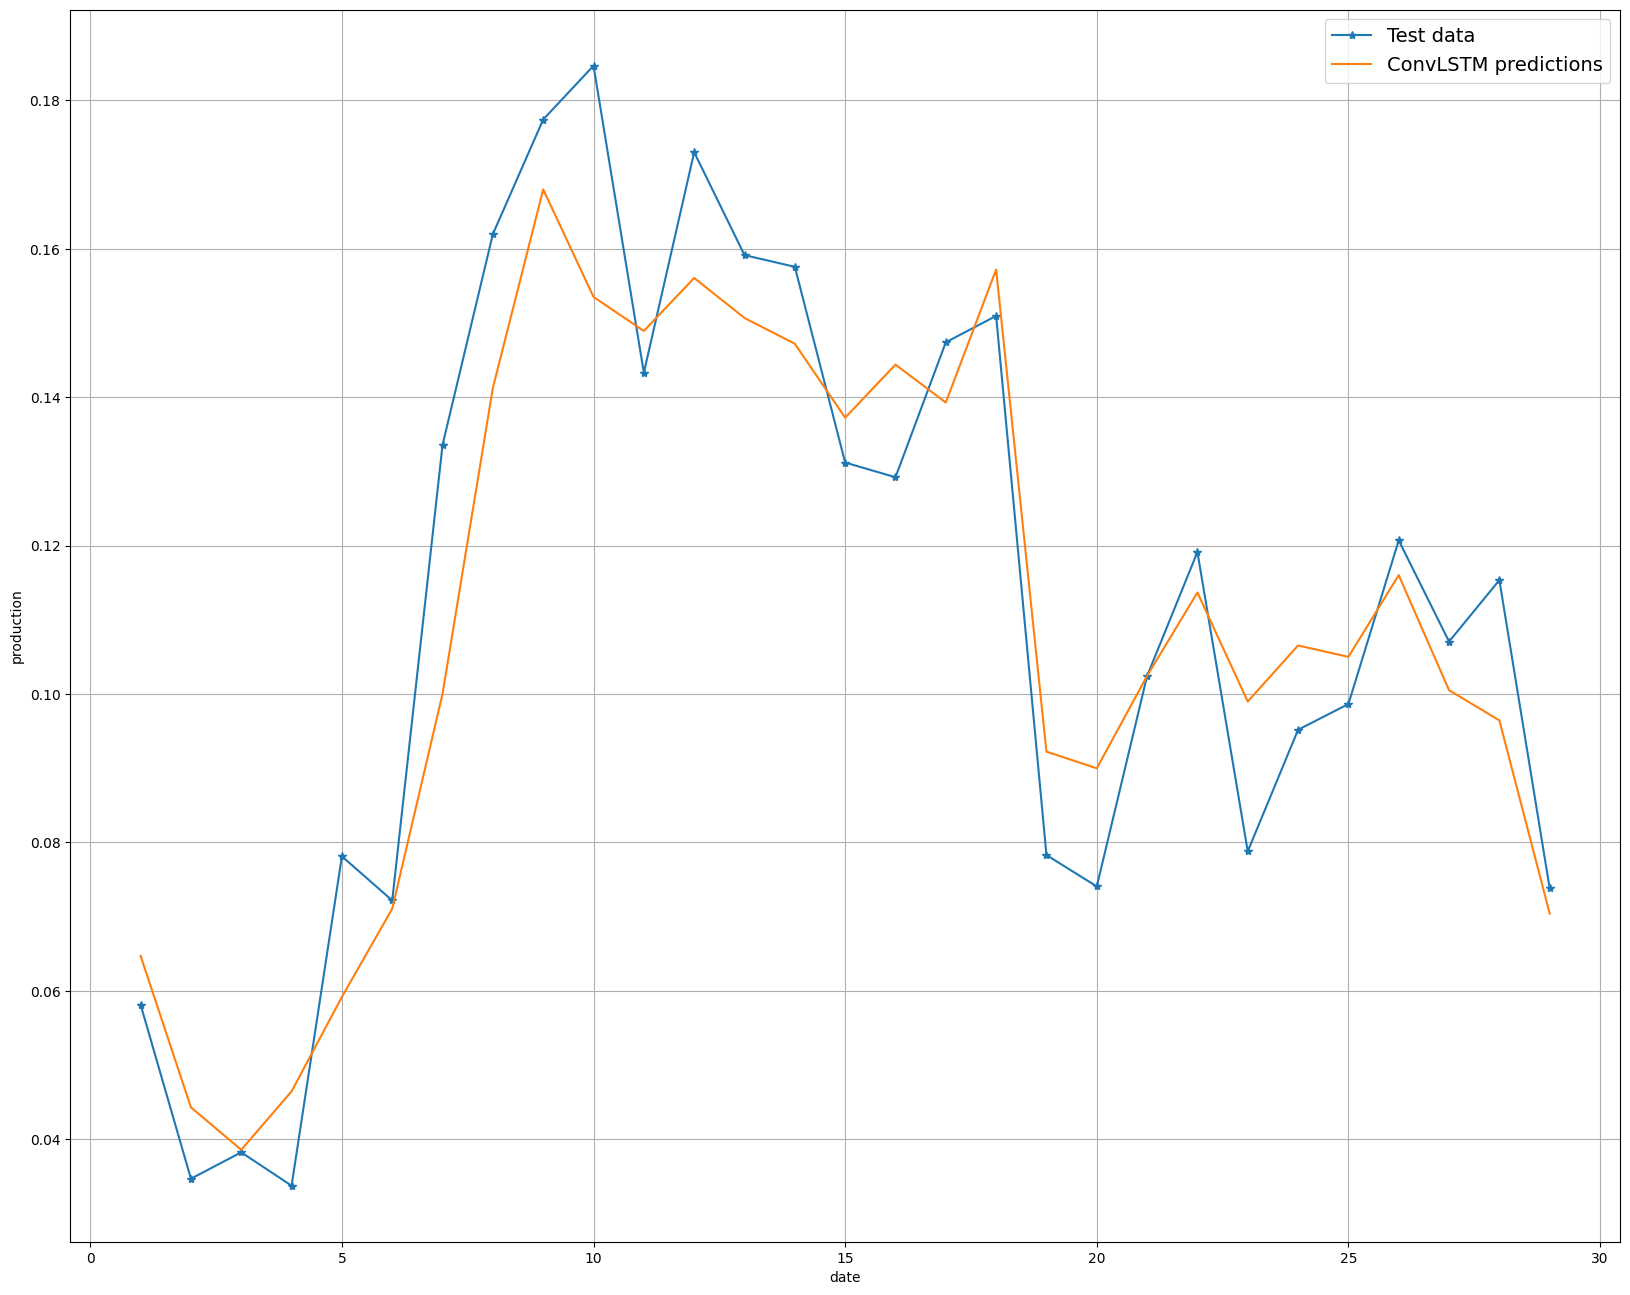

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)